# Complete Story Generation Workflow

This notebook demonstrates the complete end-to-end workflow for generating a visual story:
1. **Generate Story Outline** - Create the story structure
2. **Generate Complete Story** - Generate full story with dialogue and narration
3. **Generate Story Images** - Create images for each section of the story

**Note**: Make sure to update the API_BASE_URL, CLIENT_ID, USERNAME, and PASSWORD with your actual values.

## Setup and Authentication

In [1]:
import os
import json
import requests
import boto3
from pprint import pprint
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime

# Set AWS environment
os.environ['AWS_PROFILE'] = 'sandbox'
os.environ['AWS_REGION'] = 'us-east-1'

# Set up output directory for saving responses
NOTEBOOK_DIR = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
OUTPUT_DIR = os.path.join(NOTEBOOK_DIR, 'outputs')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# API Configuration - UPDATE THESE VALUES
API_BASE_URL = 'https://a3aflxx1o2.execute-api.us-east-1.amazonaws.com/dev'  # Update with your API Gateway URL
CLIENT_ID = '1lsusuo902uhpki5tvggo6k16g'  # Update with your Cognito client ID
USERNAME = 'admin@example.com'  # Update with your username
PASSWORD = 'NewPassword123!'  # Update with your password

print("✓ Configuration loaded")
print(f"✓ Output directory: {OUTPUT_DIR}")

✓ Configuration loaded
✓ Output directory: /Users/michaelyang/Desktop/Repositories/aws-hackathon-2025/notebooks/outputs


In [2]:
# QUICK FIX: Set up output directory if not already set
if 'OUTPUT_DIR' not in globals():
    NOTEBOOK_DIR = os.getcwd()
    OUTPUT_DIR = os.path.join(NOTEBOOK_DIR, 'outputs')
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"✓ Output directory created: {OUTPUT_DIR}")
else:
    print(f"✓ Output directory already set: {OUTPUT_DIR}")


✓ Output directory already set: /Users/michaelyang/Desktop/Repositories/aws-hackathon-2025/notebooks/outputs


In [3]:
# Get authentication token
print("🔐 Getting authentication token...")

cognito_client = boto3.client('cognito-idp', region_name='us-east-1')

auth_response = cognito_client.initiate_auth(
    ClientId=CLIENT_ID,
    AuthFlow='USER_PASSWORD_AUTH',
    AuthParameters={
        'USERNAME': USERNAME,
        'PASSWORD': PASSWORD
    }
)

TOKEN = auth_response['AuthenticationResult']['IdToken']
print(f"✓ Token obtained ({len(TOKEN)} characters)")

# Prepare headers for API calls
headers = {
    'Authorization': TOKEN,
    'Content-Type': 'application/json'
}

# Initialize S3 client for downloading images
s3_client = boto3.client('s3', region_name='us-east-1')

print("✓ Authentication complete")

🔐 Getting authentication token...
✓ Token obtained (1118 characters)
✓ Authentication complete


## Step 1: Generate Story Outline

First, we'll generate a story outline for a visual story. This creates the structure and high-level narrative for our story.

In [4]:
print("📋 STEP 1: Generate Story Outline (Visual Story)")
print("=" * 70)

# Generate unique job ID
job_id_base = f"complete-workflow-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
outline_job_id = f"{job_id_base}-outline"

outline_payload = {
    "genre": "adventure",
    "reading_level": "elementary",
    "tone": "lighthearted",
    "user_input_description": "A brave little mouse named Max who discovers a magical cheese that grants wishes",
    "story_type": "visual",
    "number_of_speakers": 3,
    "panels": 6,
    "job_id": outline_job_id,
    "model_id": "bedrock/openai.gpt-oss-120b-1:0"
}

print("\n📤 Request payload:")
pprint(outline_payload)

print("\n⏳ Sending request to generate story outline...")
response = requests.post(
    f"{API_BASE_URL}/generate-story-outline",
    headers=headers,
    json=outline_payload
)

print(f"\n📥 Response Status: {response.status_code}")

if response.status_code == 200:
    outline_response = response.json()
    print("\n✅ SUCCESS - Story outline generation successful")
    print("\n📋 Outline Response:")
    pprint(outline_response)
    
    # Extract story_parts for next step
    story_parts = outline_response['result']['story_parts']
    speaker_names = outline_response['result']['speaker_names']
    
    print(f"\n📝 Extracted {len(story_parts)} story parts")
    print(f"🎭 Speaker names: {', '.join(speaker_names)}")
    
    # Save outline response
    output_file = "workflow_step1_outline.json"
    with open(output_file, 'w') as f:
        json.dump(outline_response, f, indent=2)
    print(f"💾 Outline saved to: {output_file}")
else:
    print(f"\n❌ FAILED - Expected 200 but got {response.status_code}")
    print("\nError response:")
    pprint(response.json())
    raise Exception("Step 1 failed - Story outline generation")

📋 STEP 1: Generate Story Outline (Visual Story)

📤 Request payload:
{'genre': 'adventure',
 'job_id': 'complete-workflow-20251017-105710-outline',
 'model_id': 'bedrock/openai.gpt-oss-120b-1:0',
 'number_of_speakers': 3,
 'panels': 6,
 'reading_level': 'elementary',
 'story_type': 'visual',
 'tone': 'lighthearted',
 'user_input_description': 'A brave little mouse named Max who discovers a '
                           'magical cheese that grants wishes'}

⏳ Sending request to generate story outline...

📥 Response Status: 200

✅ SUCCESS - Story outline generation successful

📋 Outline Response:
{'authenticated_user': {'email': 'admin@example.com',
                        'sub': '24e8e4f8-0061-70c1-0b17-2508a1b5b9a6',
                        'username': '24e8e4f8-0061-70c1-0b17-2508a1b5b9a6'},
 'request_id': '633808b5-2b17-46e8-a720-a678c7c7143d',
 'result': {'metadata': {'created_timestamp': '2025-10-17T14:57:38.328086+00:00',
                         'genre': 'adventure',
              

## Step 2: Generate Complete Story

Using the outline from Step 1, we'll now generate the complete story with all dialogue and narration.

In [5]:
print("📋 STEP 2: Generate Complete Story")
print("=" * 70)

story_job_id = f"{job_id_base}-story"

story_payload = {
    "genre": "adventure",
    "reading_level": "elementary",
    "tone": "lighthearted",
    "story_outline_description": story_parts,
    "story_type": "visual",
    "number_of_speakers": 3,
    "panels": 6,
    "job_id": story_job_id,
    "model_id": "bedrock/openai.gpt-oss-120b-1:0"
}

print("\n📤 Sending request to generate complete story...")
print(f"   Using story outline from Step 1")

response = requests.post(
    f"{API_BASE_URL}/generate-story",
    headers=headers,
    json=story_payload
)

print(f"\n📥 Response Status: {response.status_code}")

if response.status_code == 200:
    story_response = response.json()
    print("\n✅ SUCCESS - Complete story generation successful")
    
    # Extract story parts for image generation
    complete_story_parts = story_response['result']['story_parts']
    
    # Count total segments
    total_segments = 0
    total_sections = 0
    for part in complete_story_parts:
        total_sections += len(part['sections'])
        for section in part['sections']:
            total_segments += len(section['segments'])
    
    print(f"\n📊 Story Statistics:")
    print(f"   - Story parts: {len(complete_story_parts)}")
    print(f"   - Total sections: {total_sections}")
    print(f"   - Total segments: {total_segments}")
    
    # Display a sample segment
    print("\n📖 Sample segment (first segment):")
    first_segment = complete_story_parts[0]['sections'][0]['segments'][0]
    print(f"   Speaker: {first_segment['speaker']}")
    print(f"   Content: {first_segment['segment_content']}")
    
    # Save story response
    output_file = "workflow_step2_story.json"
    with open(output_file, 'w') as f:
        json.dump(story_response, f, indent=2)
    print(f"\n💾 Complete story saved to: {output_file}")
else:
    print(f"\n❌ FAILED - Expected 200 but got {response.status_code}")
    print("\nError response:")
    pprint(response.json())
    raise Exception("Step 2 failed - Complete story generation")

📋 STEP 2: Generate Complete Story

📤 Sending request to generate complete story...
   Using story outline from Step 1

📥 Response Status: 200

✅ SUCCESS - Complete story generation successful

📊 Story Statistics:
   - Story parts: 3
   - Total sections: 6
   - Total segments: 18

📖 Sample segment (first segment):
   Speaker: Narrator
   Content: In a sunny kitchen corner, a brave little mouse named Max scurries along a pantry shelf, his whiskers twitching with excitement.

💾 Complete story saved to: workflow_step2_story.json


## Step 3: Generate Story Images

Finally, we'll generate images for each section of the story. Each section will get one image that represents all the segments within that section.


In [6]:
print("📋 STEP 3: Generate Story Images")
print("=" * 70)

image_job_id = f"{job_id_base}-images"

# Prepare payload with story segments from post-processing
image_payload = {
    "complete_story_parts": complete_story_parts,
    "art_style": "whimsical watercolor illustration",
    "number_of_panels": story_response['result']['metadata']['panels'],
    "job_id": image_job_id
}

print(f"\n📤 Sending request to generate story images...")
print("   ⏳ Note: Image generation may take 30-60 seconds per image...")

response = requests.post(
    f"{API_BASE_URL}/generate-story-image",
    headers=headers,
    json=image_payload
)

print(f"\n📥 Response Status: {response.status_code}")



📋 STEP 3: Generate Story Images

📤 Sending request to generate story images...
   ⏳ Note: Image generation may take 30-60 seconds per image...

📥 Response Status: 200



✅ SUCCESS - Story images generation successful

🖼️  Generated 6 images

📋 Image details:

   Section 1:
   - S3 URI: s3://story-42-story-images-dev/users/24e8e4f8-0061-70c1-0b17-2508a1b5b9a6/jobs/complete-workflow-20251016-163045-images/segment_1.png
   - Presigned URL: https://story-42-story-images-dev.s3.amazonaws.com/users/24e8e4f8-0061-70c1-0b17...
   - Content: Scene description: "In the pantry's cozy nook, crumbs sparkle like tiny stars as Max the brave littl...

   Section 2:
   - S3 URI: s3://story-42-story-images-dev/users/24e8e4f8-0061-70c1-0b17-2508a1b5b9a6/jobs/complete-workflow-20251016-163045-images/segment_2.png
   - Presigned URL: https://story-42-story-images-dev.s3.amazonaws.com/users/24e8e4f8-0061-70c1-0b17...
   - Content: Scene description: "A soft, friendly voice floats from the cheese, saying it can grant wishes." A di...

   Section 3:
   - S3 URI: s3://story-42-story-images-dev/users/24e8e4f8-0061-70c1-0b17-2508a1b5b9a6/jobs/complete-workflow-20251016-163045-i

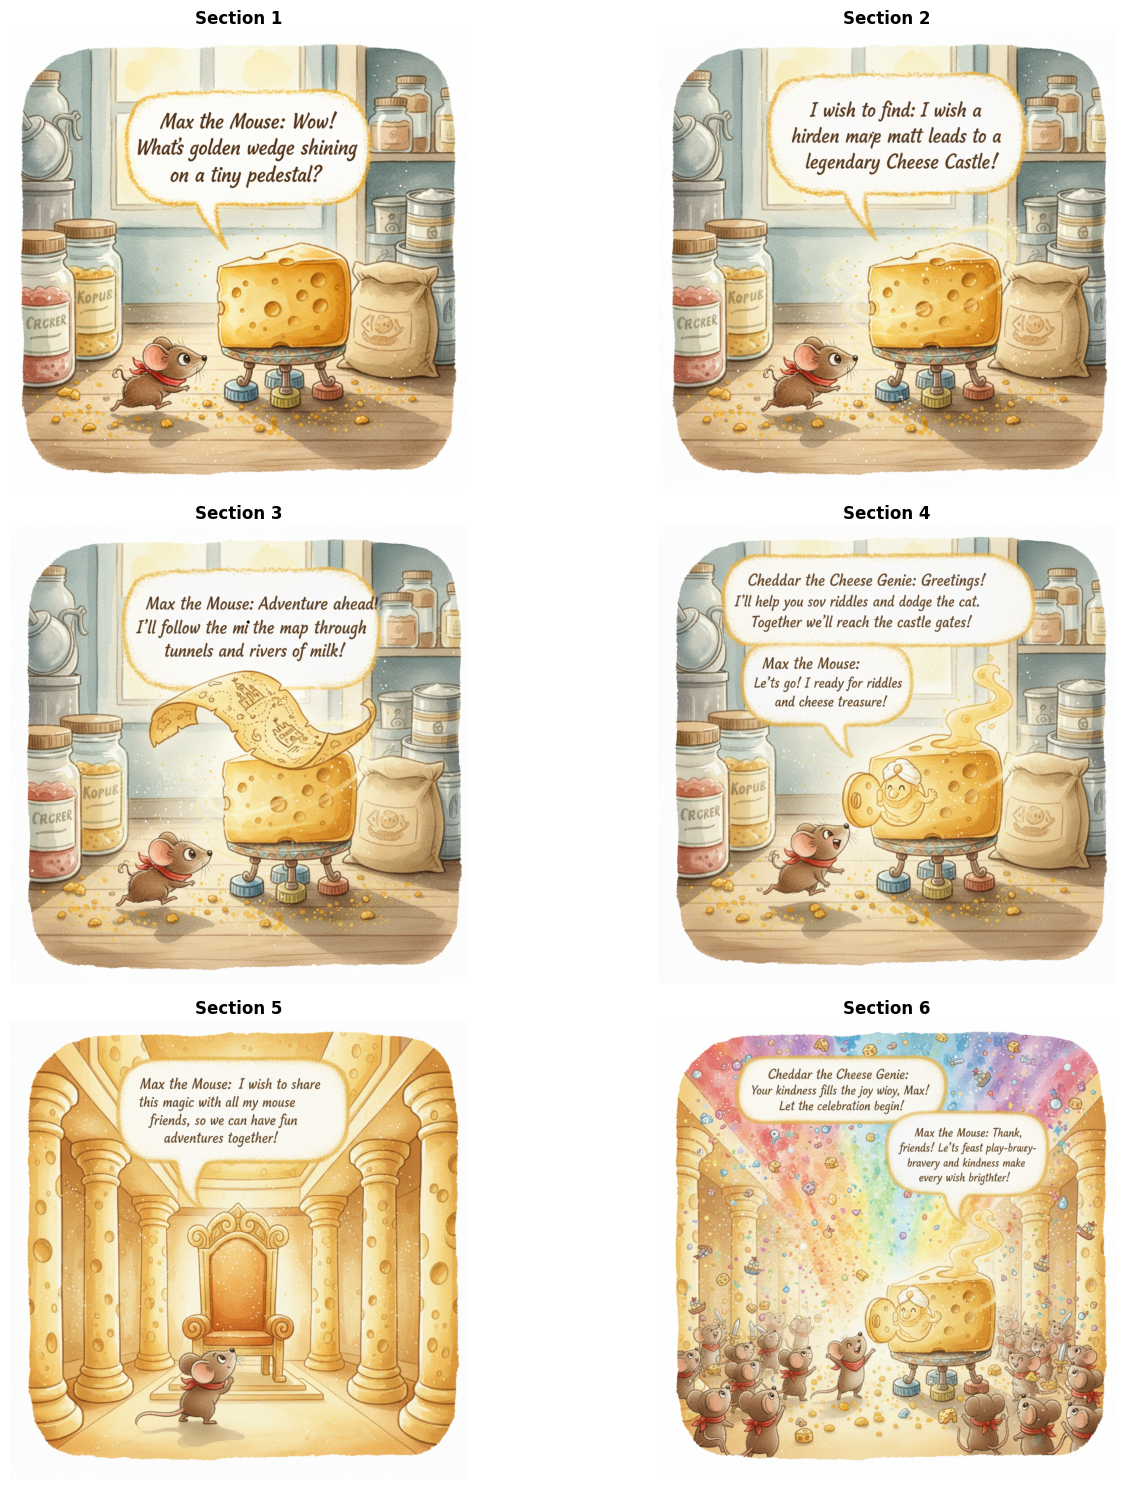


✅ Successfully displayed 6 images

💾 Image data saved to: /Users/michaelyang/Desktop/Repositories/aws-hackathon-2025/notebooks/outputs/workflow_step3_images.json


In [7]:
if response.status_code == 200:
    image_response = response.json()
    print("\n✅ SUCCESS - Story images generation successful")
    
    # Extract generated images from response
    if 'result' in image_response and 'story_segments' in image_response['result']:
        generated_story_segments = image_response['result']['story_segments']
        
        print(f"\n🖼️  Generated {len(generated_story_segments)} images")
        print("\n📋 Image details:")
        for segment in generated_story_segments:
            seg_num = segment.get('story_segment_number', 'N/A')
            s3_uri = segment.get('image_s3_uri', 'N/A')
            presigned_url = segment.get('image_presigned_url', 'N/A')
            print(f"\n   Section {seg_num}:")
            print(f"   - S3 URI: {s3_uri}")
            print(f"   - Presigned URL: {presigned_url[:80]}..." if len(str(presigned_url)) > 80 else f"   - Presigned URL: {presigned_url}")
            if 'story_segment_content' in segment:
                content_preview = segment['story_segment_content'][:100]
                print(f"   - Content: {content_preview}...")
        
        # Display images inline using presigned URLs
        print("\n\n🖼️  Displaying Generated Images:")
        print("=" * 70)
        
        num_images = len(generated_story_segments)
        if num_images > 0:
            # Calculate grid layout (2 columns)
            cols = 2
            rows = (num_images + cols - 1) // cols
            
            fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
            if rows == 1:
                axes = axes.reshape(1, -1)  # Ensure 2D array
            
            for idx, segment in enumerate(generated_story_segments):
                row = idx // cols
                col = idx % cols
                ax = axes[row, col]
                
                presigned_url = segment.get('image_presigned_url')
                seg_num = segment.get('story_segment_number', idx + 1)
                
                if presigned_url and presigned_url != 'N/A':
                    try:
                        # Download image from presigned URL
                        img_response = requests.get(presigned_url, timeout=30)
                        if img_response.status_code == 200:
                            img = Image.open(BytesIO(img_response.content))
                            
                            # Display image
                            ax.imshow(img)
                            ax.axis('off')
                            ax.set_title(f"Section {seg_num}", fontsize=12, fontweight='bold')
                            
                            print(f"✓ Displayed image for Section {seg_num}")
                        else:
                            ax.text(0.5, 0.5, f"Failed to load\nSection {seg_num}", 
                                   ha='center', va='center', transform=ax.transAxes)
                            ax.axis('off')
                            print(f"✗ Failed to load image for Section {seg_num}: Status {img_response.status_code}")
                    except Exception as e:
                        ax.text(0.5, 0.5, f"Error loading\nSection {seg_num}", 
                               ha='center', va='center', transform=ax.transAxes)
                        ax.axis('off')
                        print(f"✗ Error loading image for Section {seg_num}: {str(e)}")
                else:
                    ax.text(0.5, 0.5, f"No URL\nSection {seg_num}", 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.axis('off')
                    print(f"✗ No presigned URL for Section {seg_num}")
            
            # Hide any unused subplots
            for idx in range(num_images, rows * cols):
                row = idx // cols
                col = idx % cols
                axes[row, col].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print(f"\n✅ Successfully displayed {num_images} images")
        else:
            print("⚠️  No images to display")
        
        # Save image response
        output_file = os.path.join(OUTPUT_DIR, "workflow_step3_images.json")
        with open(output_file, 'w') as f:
            json.dump(image_response, f, indent=2)
        print(f"\n💾 Image data saved to: {output_file}")
    else:
        print("\n⚠️  WARNING - Unexpected response format")
        generated_story_segments = []
else:
    print(f"\n❌ FAILED - Expected 200 but got {response.status_code}")
    print("\nError response:")
    pprint(response.json())
    raise Exception("Step 3 failed - Story image generation")